# Practice overturning calculation

`cd project/seniorthesis/notebooks`

`conda list PyCO2SYS`

`pip install PyCO2SYS`

`pip install git+https://github.com/jbusecke/cmip6_preprocessing.git`

`mv *.png ../figures`

In [1]:
import xarray as xr
import xesmf as xe
from cmip6_preprocessing.preprocessing import combined_preprocessing
# import PyCO2SYS as pyco2 # i have to install this package through terminal for it to work
import intake
import matplotlib.pyplot as plt
import numpy as np
import warnings
import gsw
from cmip6_preprocessing.postprocessing import combine_datasets
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.path as mpath
from cmip6_preprocessing.postprocessing import combine_datasets
from cmip6_preprocessing.postprocessing import merge_variables
from dask.diagnostics import ProgressBar
from xgcm import Grid
from xhistogram.xarray import histogram
import pandas as pd
import scipy

In [2]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

## Just going to get the regular dataset for CESM2-FV2

In [17]:
dd_CESM2FV2 = {}
dd_CESM2FV2['CESM2-FV2.gr.historical.Omon']= xr.open_mfdataset('CESM2-FV2_*_20yr.nc')
for name, ds in dd_CESM2FV2.items():
    # da = dd_x[name]
    ds['p'] = gsw.p_from_z(-1*ds['lev'], ds['y'], geo_strf_dyn_height=0, sea_surface_geopotential=0)*xr.ones_like(ds['talk']) # expand along time dimension
    ds['insitutemp'] = gsw.t_from_CT(ds['so'], ds['thetao'], ds['p'])
    # ds['sigma2'] = gsw.sigma2(da['so'],da['thetao']).isel(x=slice(180,200)).mean('x', keep_attrs=True)
    ds['sigma0'] = gsw.sigma0(ds['so'],ds['thetao'])
    # ds['sigma1'] = gsw.sigma1(da['so'],da['thetao']).isel(x=slice(180,200)).mean('x', keep_attrs=True)

## Area

In [6]:
variables = ['areacello']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Ofx'], 
             variable_id=variables,
             grid_label=['gr'],
              source_id=['GFDL-ESM4']
            )


cat = col.search(**query)

# print(cat.df['source_id'].unique())
dd_A = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)

# dd_gr = merge_variables(dd_gr)

# temp={}
# for name,item in dd_gr.items():
#     #print(name)
#     #print(item.data_vars)
#     present = item.data_vars
#     if all(i in present for i in variables):
#         #print(name)
#         temp[name]=item
# dd_gr = temp
# list(dd_new_gr.keys())

dd_A = combine_datasets(
    dd_A,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_A.keys())
# dd_new_new_gr

newcoords = {'x':dd_A['GFDL-ESM4.gr.historical.Ofx'].areacello['x'], 'y':dd_A['GFDL-ESM4.gr.historical.Ofx'].areacello['y']}



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [23]:
for name, ds in dd_CESM2FV2.items():
    dd_CESM2FV2[name] = ds.assign_coords(**newcoords)
    d = dd_CESM2FV2[name]
    d['area'] = dd_A['GFDL-ESM4.gr.historical.Ofx'].areacello
    dd_CESM2FV2[name] = d

In [24]:
d

<xarray.Dataset>
Dimensions:     (y: 180, x: 360, lev: 33)
Coordinates:
  * y           (y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * x           (x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    lon         (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    lat         (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
  * lev         (lev) float64 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
Data variables:
    dissic      (lev, y, x) float32 dask.array<chunksize=(33, 180, 360), meta=np.ndarray>
    fgco2       (y, x) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    so          (lev, y, x) float32 dask.array<chunksize=(33, 180, 360), meta=np.ndarray>
    talk        (lev, y, x) float32 dask.array<chunksize=(33, 180, 360), meta=np.ndarray>
    thetao      (lev, y, x) float32 dask.array<chunksize=(33, 180, 360), meta=np.ndarray>
    p           (lev, y, x) float64 dask.array<chunksize=(33, 180, 360), meta=np.ndarray>
    insitutemp  (lev, y, x) float64 dask.array<chunksize=(33, 180, 360), meta=np.ndarray>
    sigma0      (lev, y, x) float64 dask.array<chunksize=(33, 180, 360), meta=np.ndarray>
    area        (y, x) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>

## Going to practice the calculation with `CESM2-FV2.gn.historical.Omon.r1i1p1f1`

In [53]:
variables = ['vo', 'thetao', 'so']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Omon'], 
             variable_id=variables,
             member_id = ['r1i1p1f1'],
             grid_label=['gn'],
              source_id=['CESM2-FV2']
            )


cat = col.search(**query)

# print(cat.df['source_id'].unique())
dd_gn = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)

dd_gn = merge_variables(dd_gn)
# list(dd_new.keys())

# temp={}
# for name,item in dd_gn.items():
#     #print(name)
#     #print(item.data_vars)
#     present = item.data_vars
#     if all(i in present for i in variables):
#         #print(name)
#         temp[name]=item
# dd_gn = temp


# dd_gn = combine_datasets(
#     dd_gn,
#     pick_first_member,
#     match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
# )

list(dd_gn.items())
# dd_new_new_gn


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


[('CESM2-FV2.gn.historical.Omon.r1i1p1f1',
  <xarray.Dataset>
  Dimensions:        (time: 1980, lev: 60, y: 384, x: 320, vertex: 4, bnds: 2)
  Coordinates:
    * y              (y) int32 1 2 3 4 5 6 7 8 ... 377 378 379 380 381 382 383 384
    * x              (x) int32 1 2 3 4 5 6 7 8 ... 313 314 315 316 317 318 319 320
      lat            (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
      lat_verticies  (y, x, vertex) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    * lev            (lev) float64 5.0 15.0 25.0 ... 4.875e+03 5.125e+03 5.375e+03
      lev_bounds     (lev, bnds) float32 dask.array<chunksize=(60, 2), meta=np.ndarray>
      lon            (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
      lon_verticies  (y, x, vertex) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    * time           (time) object 1850-01-15 13:00:00 ... 2014-12-15 12:00:00
      time_bounds    (time, bnds) object dask.array<chunksize=

In [54]:
dd_gn['CESM2-FV2.gn.historical.Omon.r1i1p1f1'] = dd_gn['CESM2-FV2.gn.historical.Omon.r1i1p1f1'].isel(time = slice(0,239)).mean('time',keep_attrs=True)

In [55]:
for name, ds in dd_gn.items():
    # ds['p'] = gsw.p_from_z(-1*ds['lev'], ds['y'], geo_strf_dyn_height=0, sea_surface_geopotential=0)*xr.ones_like(ds['talk']) # expand along time dimension
    # ds['insitutemp'] = gsw.t_from_CT(ds['so'], ds['thetao'], ds['p'])
    # ds['sigma2'] = gsw.sigma2(ds['so'],ds['thetao'])
    ds['sigma0'] = gsw.sigma0(ds['so'],ds['thetao'])
    # ds['sigma1'] = gsw.sigma1(ds['so'],ds['thetao'])

In [56]:
ds = dd_gn['CESM2-FV2.gn.historical.Omon.r1i1p1f1']
ds

<xarray.Dataset>
Dimensions:        (lev: 60, y: 384, x: 320, vertex: 4, bnds: 2)
Coordinates:
  * y              (y) int32 1 2 3 4 5 6 7 8 ... 377 378 379 380 381 382 383 384
  * x              (x) int32 1 2 3 4 5 6 7 8 ... 313 314 315 316 317 318 319 320
    lat            (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lat_verticies  (y, x, vertex) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
  * lev            (lev) float64 5.0 15.0 25.0 ... 4.875e+03 5.125e+03 5.375e+03
    lev_bounds     (lev, bnds) float32 dask.array<chunksize=(60, 2), meta=np.ndarray>
    lon            (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lon_verticies  (y, x, vertex) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    lon_bounds     (bnds, y, x) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    lat_bounds     (bnds, y, x) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
Dimensions without coordinates: vertex, bnds
Data variables:
    vo             (lev, y, x) float32 dask.array<chunksize=(60, 384, 320), meta=np.ndarray>
    so             (lev, y, x) float32 dask.array<chunksize=(60, 384, 320), meta=np.ndarray>
    thetao         (lev, y, x) float32 dask.array<chunksize=(60, 384, 320), meta=np.ndarray>
    sigma0         (lev, y, x) float64 dask.array<chunksize=(60, 384, 320), meta=np.ndarray>
Attributes: (12/44)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  10950.0
    case_id:                1559
    ...                     ...
    table_id:               Omon
    variant_info:           CMIP6 CESM2-FV2 historical experiment (1850-2014)...
    variant_label:          r1i1p1f1
    version_id:             v20191120
    intake_esm_varname:     None
    external_variables:     areacello volcello

# First, I need to turn `vo` into a vertically integrated velocity. 
Supposedly, I do that by multiplying by ∆z 

In [28]:
dd_gn['CESM2-FV2.gn.historical.Omon.r1i1p1f1'].lev_bounds.diff('bnds').values

array([[ 10.      ],
       [ 10.      ],
       [ 10.      ],
       [ 10.      ],
       [ 10.      ],
       [ 10.      ],
       [ 10.      ],
       [ 10.      ],
       [ 10.      ],
       [ 10.      ],
       [ 10.      ],
       [ 10.      ],
       [ 10.      ],
       [ 10.      ],
       [ 10.      ],
       [ 10.049194],
       [ 10.239517],
       [ 10.596451],
       [ 11.090622],
       [ 11.710037],
       [ 12.459015],
       [ 13.348724],
       [ 14.395935],
       [ 15.622681],
       [ 17.056763],
       [ 18.732513],
       [ 20.692139],
       [ 22.987152],
       [ 25.67981 ],
       [ 28.845581],
       [ 32.575043],
       [ 36.976013],
       [ 42.17514 ],
       [ 48.318146],
       [ 55.56726 ],
       [ 64.095215],
       [ 74.06995 ],
       [ 85.63098 ],
       [ 98.851685],
       [113.68939 ],
       [129.93054 ],
       [147.14648 ],
       [164.68994 ],
       [181.75293 ],
       [197.4989  ],
       [211.22644 ],
       [222.51392 ],
       [231.2

In [57]:
vdz = ds['vo']*dd_gn['CESM2-FV2.gn.historical.Omon.r1i1p1f1'].lev_bounds.diff('bnds')
vdz


<xarray.DataArray (lev: 60, y: 384, x: 320, bnds: 1)>
dask.array<mul, shape=(60, 384, 320, 1), dtype=float32, chunksize=(60, 384, 320, 1), chunktype=numpy.ndarray>
Coordinates:
  * y           (y) int32 1 2 3 4 5 6 7 8 9 ... 377 378 379 380 381 382 383 384
  * x           (x) int32 1 2 3 4 5 6 7 8 9 ... 313 314 315 316 317 318 319 320
    lat         (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * lev         (lev) float64 5.0 15.0 25.0 ... 4.875e+03 5.125e+03 5.375e+03
    lon         (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lev_bounds  (lev, bnds) float32 dask.array<chunksize=(60, 1), meta=np.ndarray>
Dimensions without coordinates: bnds

## Transform into density space

In [58]:
# ds = dd['CESM2-FV2.gr.historical.Omon']
grid = Grid(ds, coords={'Z': {'center':'lev'}}, periodic=False)
target_sig0 = np.linspace(26, 28, 15)

# grid = Grid(ds, coords={'Z': {'center':'y'}}, periodic=False)
vdz_sigma0 = grid.transform(vdz, 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear')
# d = d.mean(['x'],keep_attrs=True)
vdz_sigma0

<xarray.DataArray (y: 384, x: 320, bnds: 1, sigma0: 15)>
dask.array<transpose, shape=(384, 320, 1, 15), dtype=float32, chunksize=(384, 320, 1, 15), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) int32 1 2 3 4 5 6 7 8 9 ... 376 377 378 379 380 381 382 383 384
  * x        (x) int32 1 2 3 4 5 6 7 8 9 ... 312 313 314 315 316 317 318 319 320
    lat      (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lon      (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * sigma0   (sigma0) float64 26.0 26.14 26.29 26.43 ... 27.57 27.71 27.86 28.0
Dimensions without coordinates: bnds

In [50]:
data = dd_CESM2FV2['CESM2-FV2.gr.historical.Omon']
# data['vdz'] = d

## Regrid `d` (which is `vdz` in density) onto 1°x1°
`vdz_sigma0_2` is in density space with new coordinates

In [65]:
# Regrid
targetgrid_ds = xe.util.grid_global(1.0, 1.0)
targetgrid_ds['lon'] = targetgrid_ds['lon']+180
targetgrid_ds['lon_b'] = targetgrid_ds['lon_b']+180
newcoords = {'x':targetgrid_ds['lon'][0,:],'y':targetgrid_ds['lat'][:,0]}

# dd_regrid2={}
# for name,item in dd_gn.items():
regridder = xe.Regridder(vdz_sigma0, targetgrid_ds, 'bilinear', 
                         periodic=True, ignore_degenerate=True)
ds_regridded = regridder(vdz_sigma0).assign_coords(**newcoords)
vdz_sigma0_2=ds_regridded

newcoordsA = {'x':dd_A['GFDL-ESM4.gr.historical.Ofx'].areacello['x'], 'y':dd_A['GFDL-ESM4.gr.historical.Ofx'].areacello['y']}
vdz_sigma0_2 = vdz_sigma0_2.assign_coords(**newcoordsA)
vdz_sigma0_2

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/array/core.py:450: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


<xarray.DataArray (bnds: 1, sigma0: 15, y: 180, x: 360)>
dask.array<_regrid, shape=(1, 15, 180, 360), dtype=float32, chunksize=(1, 15, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * sigma0   (sigma0) float64 26.0 26.14 26.29 26.43 ... 27.57 27.71 27.86 28.0
  * x        (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Dimensions without coordinates: bnds
Attributes:
    regrid_method:  bilinear

## `vdz_sigma0_A` (which is in density space with new coordinates) multiplied by area of the grid cell then averaged over `x`

In [67]:
vdz_sigma0_A = vdz_sigma0_2*dd_A['GFDL-ESM4.gr.historical.Ofx'].areacello
vdz_sigma0_A

<xarray.DataArray (bnds: 1, sigma0: 15, y: 180, x: 360)>
dask.array<mul, shape=(1, 15, 180, 360), dtype=float32, chunksize=(1, 15, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * sigma0   (sigma0) float64 26.0 26.14 26.29 26.43 ... 27.57 27.71 27.86 28.0
  * x        (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
    lon      (x, y) float64 0.5 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
    lat      (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Dimensions without coordinates: bnds

In [68]:
vdz_sigma0_A = vdz_sigma0_A.mean('x', keep_attrs = True)

In [69]:
vdz_sigma0_A

<xarray.DataArray (bnds: 1, sigma0: 15, y: 180)>
dask.array<mean_agg-aggregate, shape=(1, 15, 180), dtype=float32, chunksize=(1, 15, 180), chunktype=numpy.ndarray>
Coordinates:
  * sigma0   (sigma0) float64 26.0 26.14 26.29 26.43 ... 27.57 27.71 27.86 28.0
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Dimensions without coordinates: bnds

## So trying to take a cumulative sum and I think this is where it all goes wrong

/srv/conda/envs/notebook/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


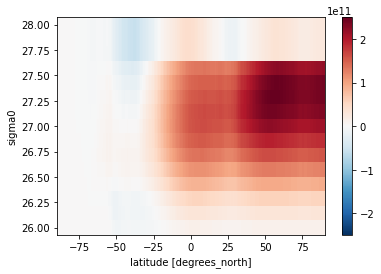

In [73]:
np.cumsum(vdz_sigma0_A).plot()

In [74]:
maybe_overturning = np.cumsum(vdz_sigma0_A).sel(y = slice(-80,-30))

/srv/conda/envs/notebook/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


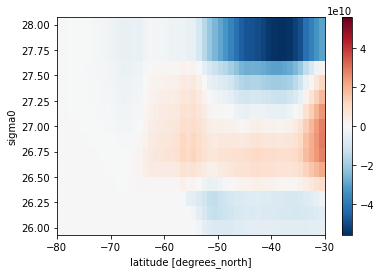

In [75]:
maybe_overturning.plot()

TypeError: Input z must be 2D, not 3D

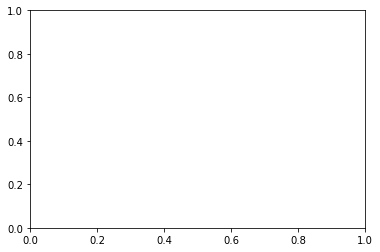

In [79]:
fig, ax = plt.subplots()

ax.contourf(maybe_overturning.y, maybe_overturning.sigma0, maybe_overturning)
ax.invert_yaxis()

In [80]:
maybe_overturning

<xarray.DataArray (bnds: 1, sigma0: 15, y: 50)>
dask.array<getitem, shape=(1, 15, 50), dtype=float32, chunksize=(1, 15, 50), chunktype=numpy.ndarray>
Coordinates:
  * sigma0   (sigma0) float64 26.0 26.14 26.29 26.43 ... 27.57 27.71 27.86 28.0
  * y        (y) float64 -79.5 -78.5 -77.5 -76.5 ... -33.5 -32.5 -31.5 -30.5
Dimensions without coordinates: bnds